### Boilerplate

In [92]:
from bs4 import BeautifulSoup
from cycler import cycler
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import json
from datetime import datetime, date, timedelta
import requests
import seaborn as sns

import pyspark.sql.functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

from IPython.core.interactiveshell import InteractiveShell
from IPython.core.display import display, HTML
InteractiveShell.ast_node_interactivity = "all"
display(HTML('<style>.container {width:90% !important;}</style>'))

plt.style.use('fivethirtyeight')
%matplotlib inline

spark.sql('CREATE DATABASE IF NOT EXISTS football_games')
spark.sql('USE football_games')

os.chdir('../football_data')

DataFrame[]

DataFrame[]

In [3]:
spark.sql('show tables').toPandas()

,database,tableName,isTemporary
0,football_games,coach,False
1,football_games,dvoa,False
2,football_games,game,False
3,football_games,game_line,False
4,football_games,game_metadata,False
5,football_games,game_outcome,False
6,football_games,games_denorm,False
7,football_games,stadium,False
8,football_games,team,False
9,football_games,team_season,False


### Matplotlib Boilerplate

In [71]:
from matplotlib import rcParams

In [73]:
filter(lambda (k,v): 'title' in k, rcParams.iteritems())

[('axes.titlepad', 6.0),
 ('axes.titlesize', u'x-large'),
 ('axes.titleweight', 'normal'),
 ('figure.titlesize', 'large'),
 ('figure.titleweight', 'normal')]

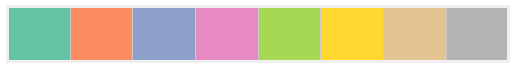

In [93]:
rcParams['axes.titleweight'] = 'bold'
rcParams['axes.titlesize'] = 14
rcParams['figure.titleweight'] = 'bold'
rcParams['text.color'] = '#262626'

## colors
color_palette = 'Set2'
colors = sns.color_palette(color_palette)
sns.palplot(sns.color_palette(color_palette))
rcParams['axes.prop_cycle'] = cycler(color=colors)

### Join/select to get needed data

In [18]:
game = spark.table('game_outcome').select('game_id','H_score','V_score').cache()

In [19]:
meta = spark.table('game_metadata').select('game_id','season','week_id','day_of_week').cache()

In [20]:
game.limit(5).toPandas()
meta.limit(5).toPandas()

,game_id,H_score,V_score
0,201511150ram,13,37
1,201511090sdg,19,22
2,201510180det,37,34
3,201512270tam,21,26
4,201510110kan,17,18


,game_id,season,week_id,day_of_week
0,200909140nwe,2009,0,0
1,200911150oti,2009,9,6
2,200912270atl,2009,15,6
3,200912130kan,2009,13,6
4,201001030min,2009,16,6


In [35]:
df = game.join(meta, on='game_id')
assert game.count() == df.count()
assert meta.count() == df.count()

In [36]:
df.limit(5).toPandas()

,game_id,H_score,V_score,season,week_id,day_of_week
0,200909140nwe,25,24,2009,0,0
1,200911150oti,41,17,2009,9,6
2,200912270atl,31,3,2009,15,6
3,200912130kan,10,16,2009,13,6
4,201001030min,44,7,2009,16,6


### Exploring Scores via Spark
* distribution of winning scores
* distribution of losing scores
* distribution of margins of victory
* distribution of (mean) winning score by year

In [81]:
df = df.withColumn(
            'winning_team', 
            F.when(col('H_score') > col('V_score'), 'H')
             .when(col('H_score') < col('V_score'), 'V')
             .otherwise('T')
        ).withColumn(
            'winning_score', 
            F.when(col('winning_team') == 'H', col('H_score'))
             .otherwise(col('V_score'))
        ).withColumn(
            'losing_score', 
            F.when(col('winning_team') == 'H', col('V_score'))
             .otherwise(col('H_score'))
        ).withColumn(
            'winning_margin', 
            F.abs(col('H_score') - col('V_score'))
        ).withColumn(
            'home_net', 
            col('H_score') - col('V_score')
        )

In [40]:
winners = df.groupby('winning_team').count().toPandas().set_index('winning_team')
print 'home team wins {:.1f}% of the time'.format(
    winners.loc['H','count'].astype(float) / winners['count'].sum()*100
)
winners

home team wins 57.0% of the time


,count
winning_team,
T,6
V,1257
H,1674


In [112]:
def agg_scores(df, ngames, scores):
    scores = df.withColumn('prop', F.lit(1) / ngames)\
                       .groupby(scores)\
                       .agg(F.sum('prop').alias('prop'))\
                       .toPandas()\
                       .set_index(scores)\
                       .sort_index()

    assert np.abs(scores['prop'].sum() - 1) < 1e-10

    new_index = np.arange(
        scores.index.min(),
        scores.index.max()+1,
    )

    return scores.reindex(new_index).fillna(0)

ngames = F.lit(float(df.count()))
winning_scores = agg_scores(df, ngames, 'winning_score')
losing_scores = agg_scores(df, ngames, 'losing_score')
margin = agg_scores(df, ngames, 'winning_margin')
home_net = agg_scores(df, ngames, 'home_net')

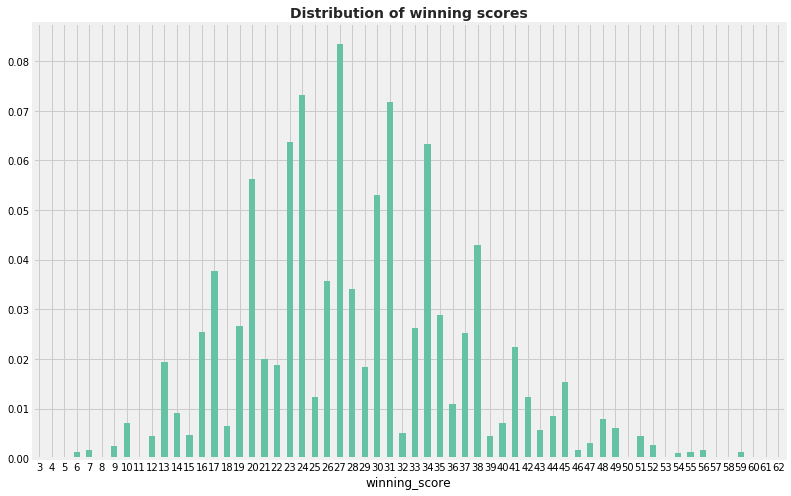

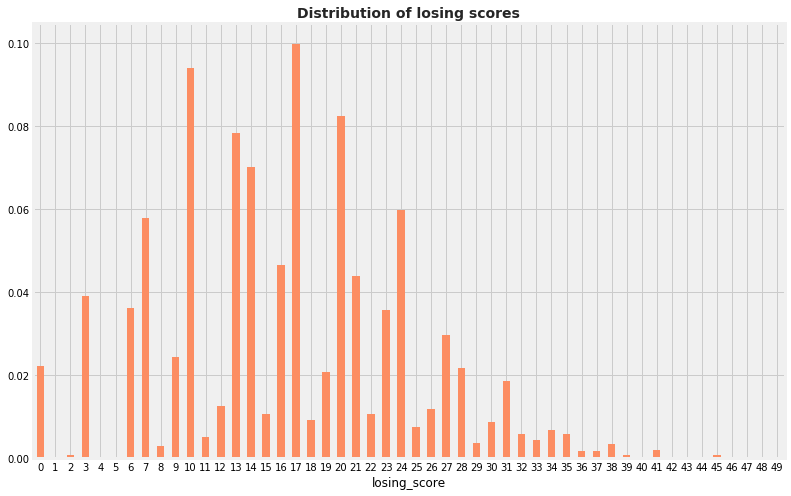

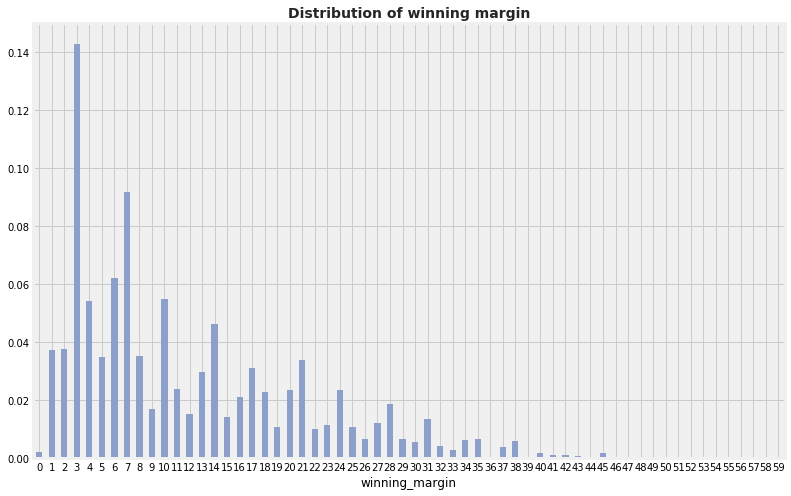

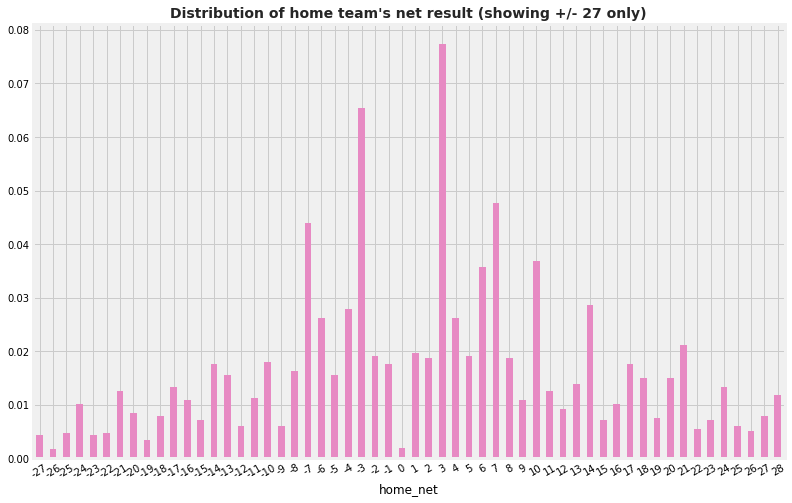

In [122]:
_ = winning_scores.plot(kind='bar', figsize=(12,8), rot=0, legend=None)
_ = plt.title(
    'Distribution of winning scores', 
    color='#262626', fontsize=14, fontweight='bold'
 )

_ = losing_scores.plot(
    kind='bar', figsize=(12,8), rot=0, legend=None, color=colors[1]
)
_ = plt.title(
    'Distribution of losing scores', color='#262626', fontsize=14, fontweight='bold'
 )

_ = margin.plot(
    kind='bar', figsize=(12,8), rot=0, legend=None, color=colors[2]
)
_ = plt.title(
    'Distribution of winning margin', 
    color='#262626', fontsize=14, fontweight='bold'
 )

_ = home_net.loc[-27:28, :].plot(
    kind='bar', figsize=(12,8), rot=30, legend=None, color=colors[3]
)
_ = plt.title(
    'Distribution of home team\'s net result (showing +/- 27 only)', 
    color='#262626', fontsize=14, fontweight='bold'
 )

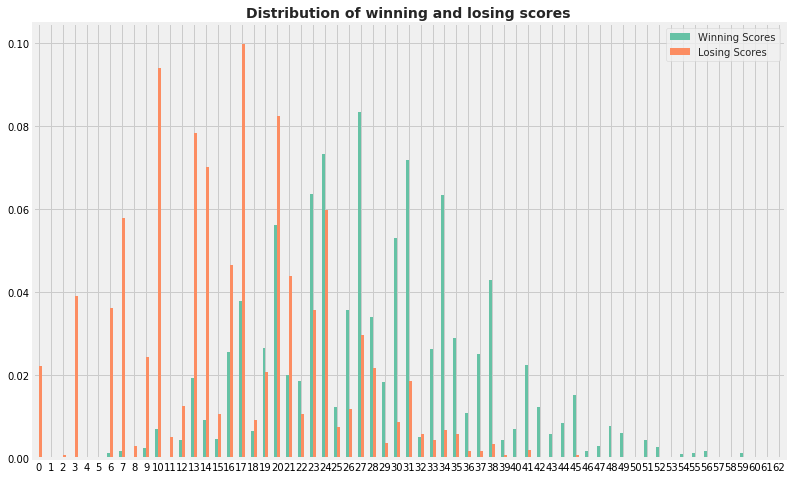

In [114]:
combined_scores = winning_scores.rename(columns={'prop':'Winning Scores'}).merge(
        losing_scores.rename(columns={'prop':'Losing Scores'}), 
        left_index=True, right_index=True, how='outer'
    ).fillna(0)

_ = combined_scores.plot(
    kind='bar', figsize=(12,8), rot=0
)
_ = plt.title(
    'Distribution of winning and losing scores', 
    color='#262626', fontsize=14, fontweight='bold'
 )

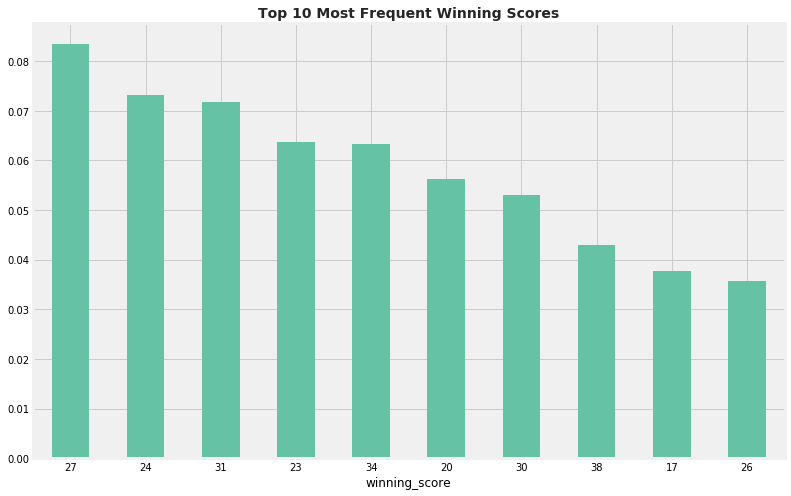

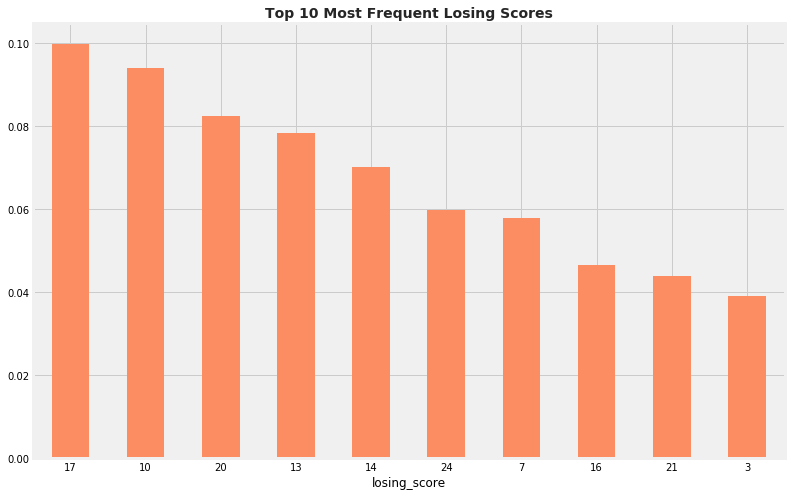

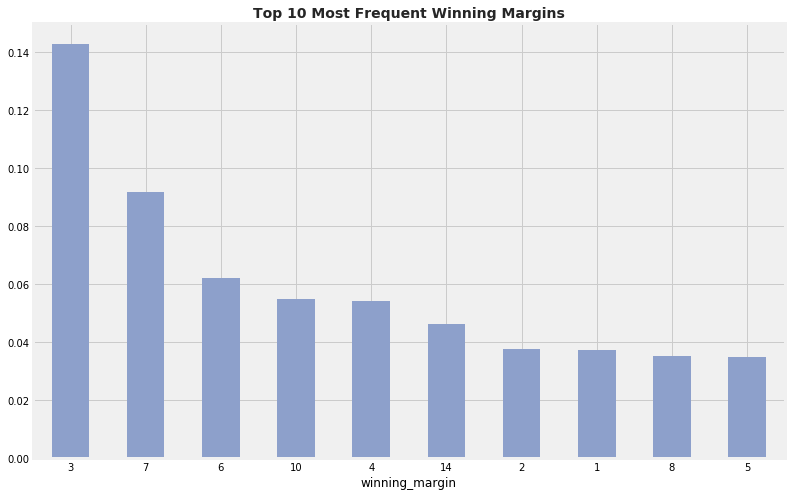

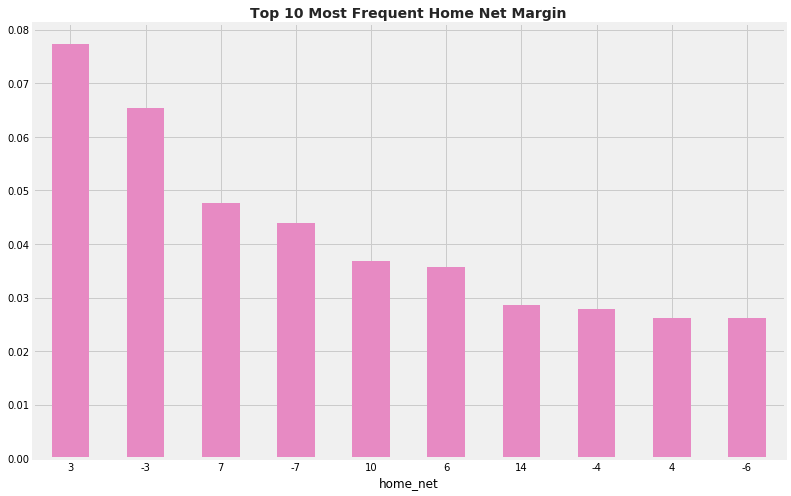

In [125]:
_ = winning_scores.sort_values(
    by='prop', ascending=False
).head(10).plot(kind='bar', figsize=(12,8), rot=0, legend=None)
_ = plt.title('Top 10 Most Frequent Winning Scores')

_ = losing_scores.sort_values(
    by='prop', ascending=False
).head(10).plot(kind='bar', figsize=(12,8), rot=0, 
                legend=None, color=colors[1])
_ = plt.title('Top 10 Most Frequent Losing Scores')

_ = margin.sort_values(
    by='prop', ascending=False
).head(10).plot(kind='bar', figsize=(12,8), rot=0, 
                legend=None, color=colors[2])
_ = plt.title('Top 10 Most Frequent Winning Margins')

_ = home_net.sort_values(
    by='prop', ascending=False
).head(10).plot(kind='bar', figsize=(12,8), rot=0, 
                legend=None, color=colors[3])
_ = plt.title('Top 10 Most Frequent Home Net Margin')



#### 6 tie games from 2007-2017... this is correct per https://en.wikipedia.org/wiki/List_of_NFL_tied_games

In [24]:
df.filter(col('winner') == 'T').toPandas()

,game_id,H_score,V_score,season,week_id,day_of_week,winner
0,201211110sfo,24,24,2012,9,6,T
1,200811160cin,13,13,2008,10,6,T
2,201311240gnb,26,26,2013,11,6,T
3,201410120cin,37,37,2014,5,6,T
4,201610230crd,6,6,2016,6,6,T
5,201610300cin,27,27,2016,7,6,T


### How does the margin of error and/or winning score change over (1) time, (2) week, (3) day of week?

In [108]:
df.limit(5).toPandas().T

,0,1,2,3,4
game_id,200909140nwe,200911150oti,200912270atl,200912130kan,201001030min
H_score,25,41,31,10,44
V_score,24,17,3,16,7
season,2009,2009,2009,2009,2009
week_id,0,9,15,13,16
day_of_week,0,6,6,6,6
winning_team,H,H,H,V,H
winning_score,25,41,31,16,44
winning_margin,1,24,28,6,37
home_net,1,24,28,-6,37


In [141]:
field = 'winning_score'
pivot_col = 'season'

time_trend = df.groupby(field)\
                .pivot(pivot_col)\
                .count()\
                .toPandas()\
                .fillna(0)\
                .set_index(field)

new_index = np.arange(
    time_trend.index.min(),
    time_trend.index.max()+1,
)

time_trend = time_trend.reindex(new_index).fillna(0)

for c in time_trend.columns:
    tot = float(time_trend[c].sum())
    time_trend[c] /= tot

time_trend.head()

,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017
winning_score,,,,,,,,,,,
3,0.003745,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
5,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000
6,0.000000,0.0,0.003745,0.000000,0.003745,0.000000,0.0,0.0,0.0,0.003745,0.003745
7,0.000000,0.0,0.003745,0.003745,0.003745,0.007491,0.0,0.0,0.0,0.000000,0.000000


In [155]:
dow_map = {
    0: 'Mon',
    1: 'Tue',
    2: 'Wed',
    3: 'Thu',
    4: 'Fri',
    5: 'Sat',
    6: 'Sun',
}
dow_map_udf = udf(lambda x: dow_map[x], StringType())

df = df.withColumn('Weekday', dow_map_udf('day_of_week'))
df.groupby('Weekday').count().toPandas().sort_values(by='count')

,Weekday,count
4,Wed,1
5,Fri,1
6,Tue,1
3,Sat,86
2,Thu,151
1,Mon,189
0,Sun,2508


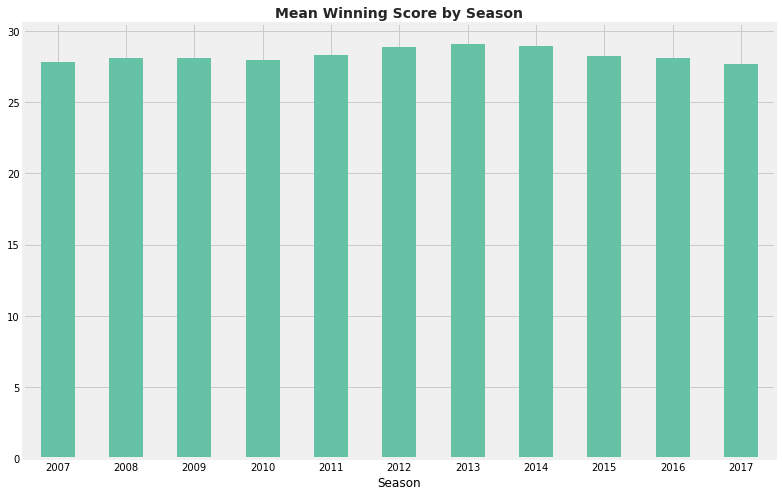

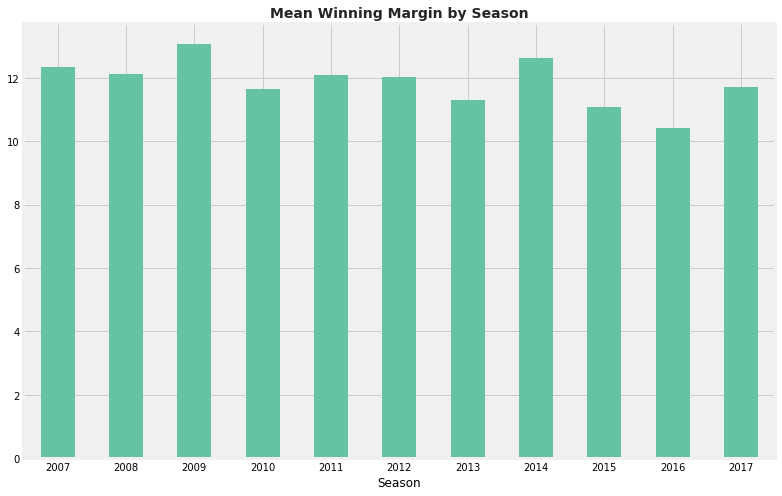

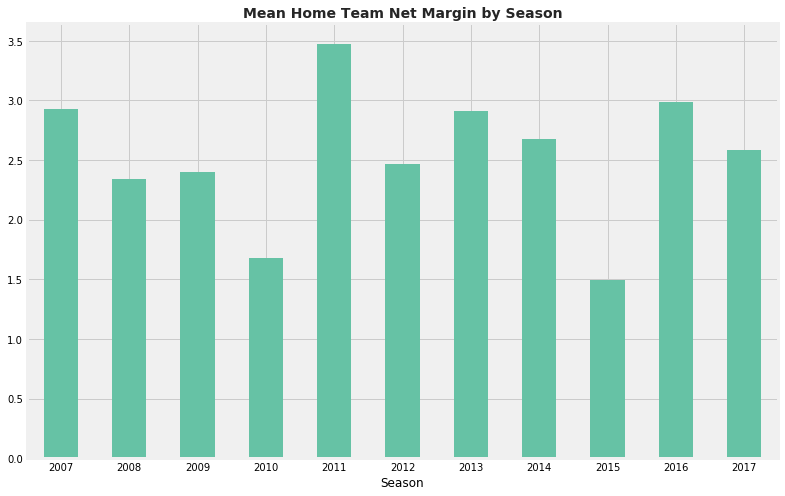

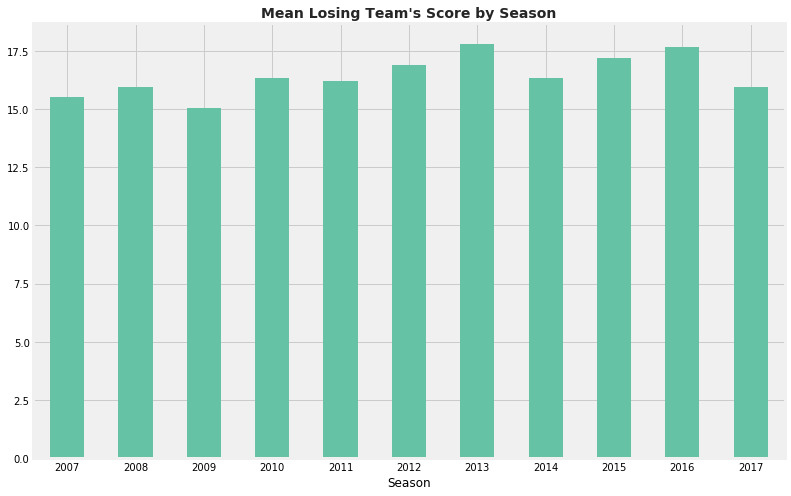

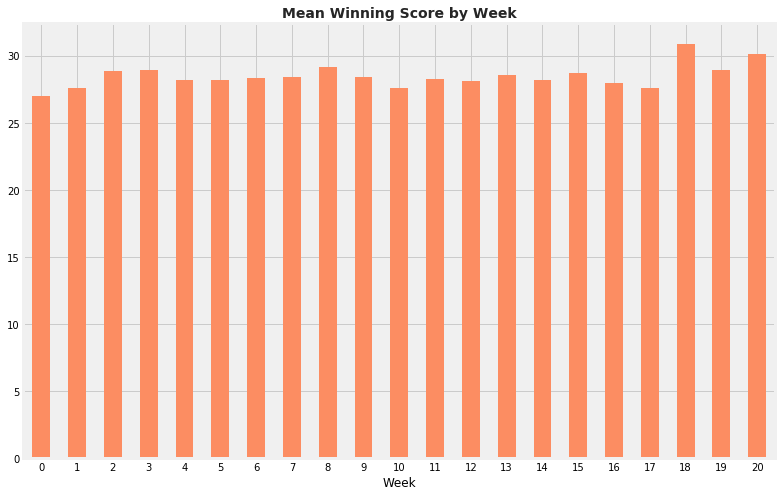

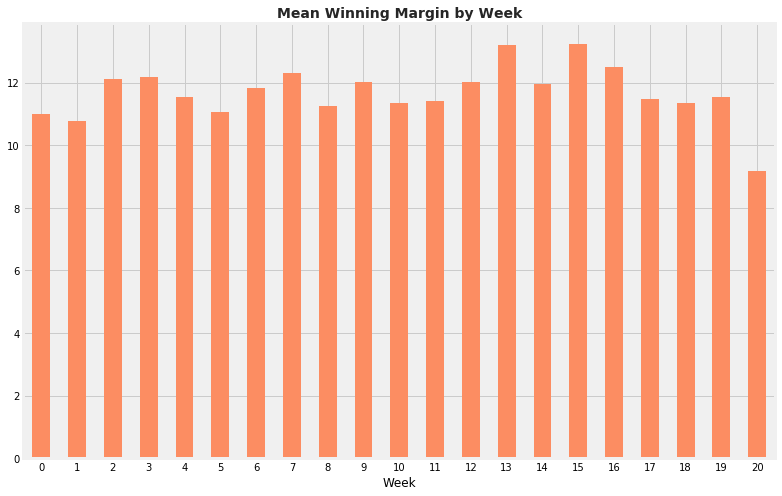

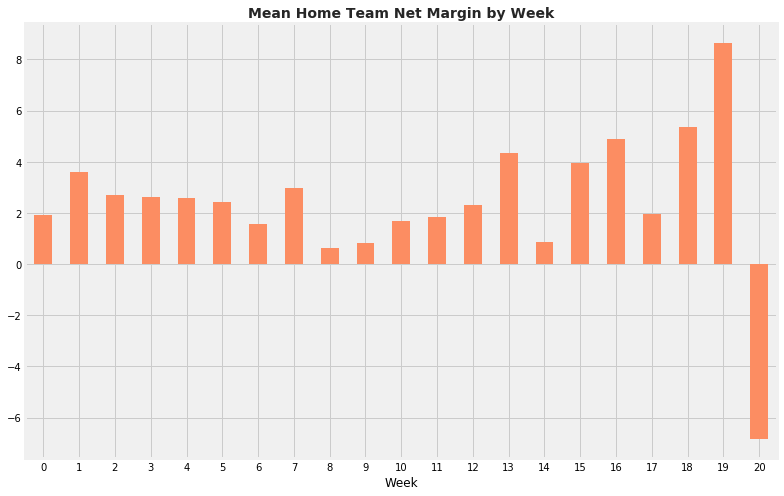

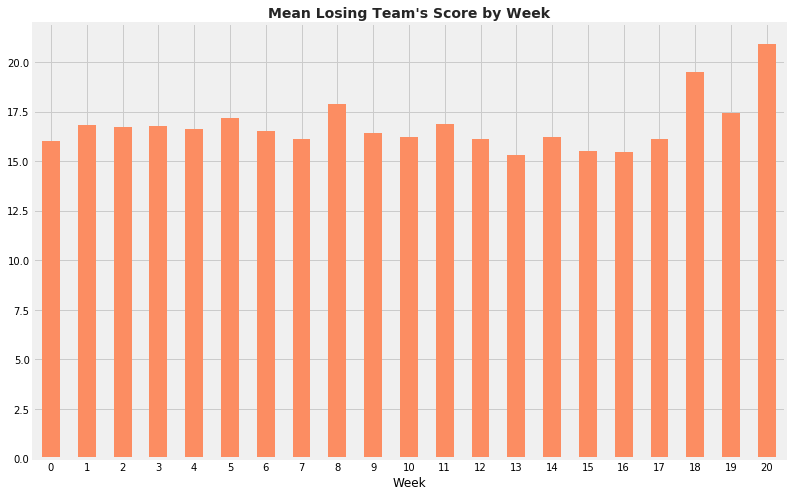

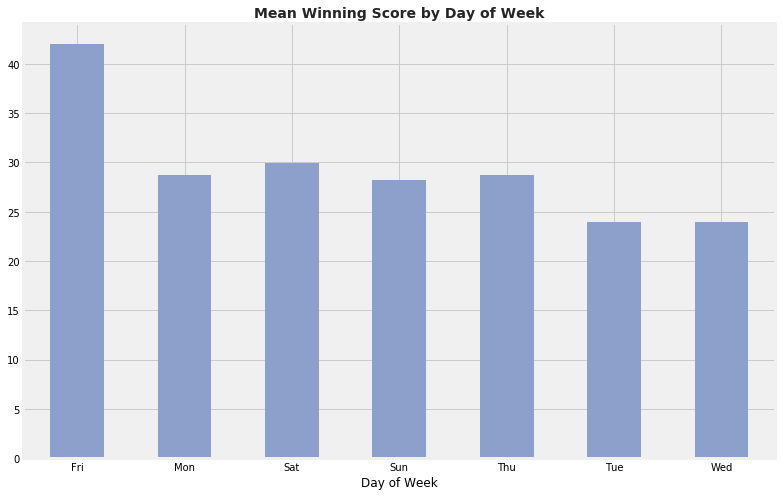

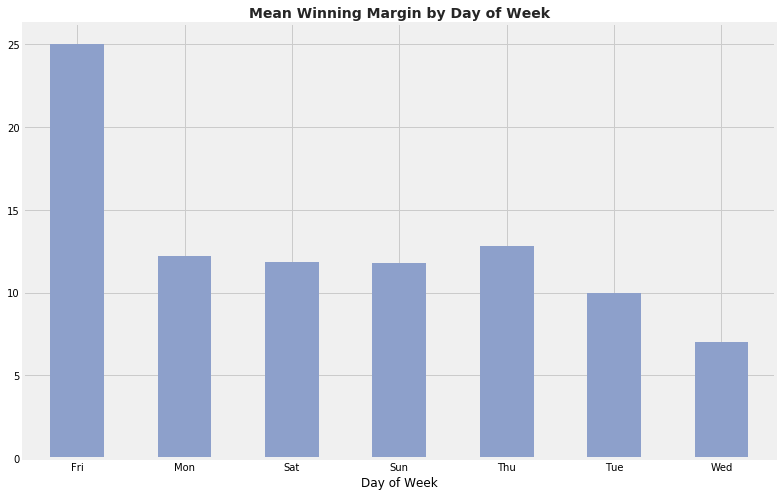

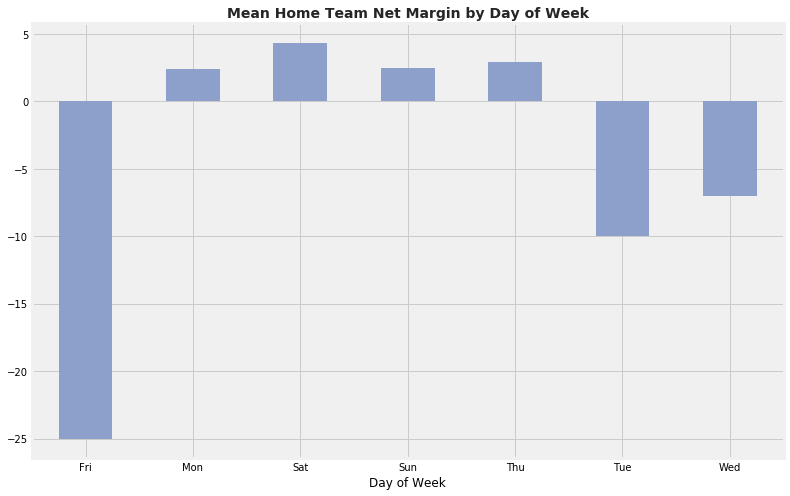

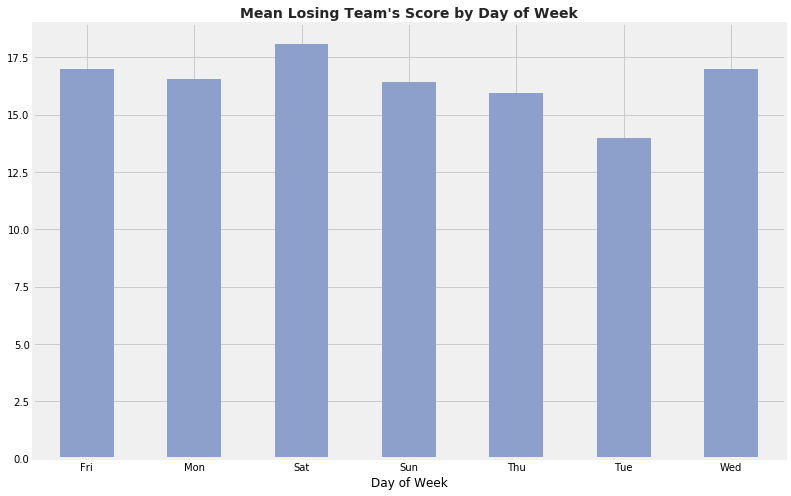

In [157]:
fields = [('season','Season'), ('week_id','Week'), ('Weekday','Day of Week')]
agg_cols = [
    ('winning_score','Winning Score'), ('winning_margin','Winning Margin'), 
    ('home_net','Home Team Net Margin'), ('losing_score', 'Losing Team\'s Score')
]

for i, (field, field_desc) in enumerate(fields):
    for (agg_col, agg_col_desc) in agg_cols:
        _ = df.groupby(field)\
                .agg(F.mean(agg_col).alias(agg_col))\
                .toPandas()\
                .set_index(field)\
                .sort_index()\
                .plot(
                    kind='bar', legend=None, rot=0, figsize=(12,8), color=colors[i]
                )
        _ = plt.title('Mean {} by {}'.format(agg_col_desc, field_desc))
        _ = plt.xlabel(field_desc)